In [1]:

"""
Our analysis will focus on the long-term impact on the Canadian economy
regarding the cost of children/minors missing out on school, or getting bad starts on their school year.
This analysis is based on a study from the World Bank in May 2020 that focused on similar factors we'll
be highlighting today
(Found in the data folder)
Lost Wages - the COVID-19 Cost of School Closures
G. Psacharopoulos, V. Collis, H.A. Patrinos & E. Vegas
http://documents1.worldbank.org/curated/en/702401598463119393/pdf/Lost-Wages-The-COVID-19-Cost-of-School-Closures.pdf

This approach relies on Human Capital Theory, where it is stipulated that investments of time and money
on education have a Human Capital building effect similar if not identical to the effect of investing
in real-physical assets such as infrastructure.


To narrow down our sample of study to model the simulation, we'll be using survey data from Abacus that studied the 
month of September 2020 in Canada, to estimate how many students missed close to a month of school, or had
sub-par educational support from schools due to various pandemic factors, during a school years' most important 
month.
"""


"\nOur analysis will focus on the long-term impact on the Canadian economy\nregarding the cost of children/minors missing out on school, or getting bad starts on their school year.\nThis analysis is based on a study from the World Bank in May 2020 that focused on similar factors we'll\nbe highlighting today\nLost Wages - the COVID-19 Cost of School Closures\nG. Psacharopoulos, V. Collis, H.A. Patrinos & E. Vegas\nhttp://documents1.worldbank.org/curated/en/702401598463119393/pdf/Lost-Wages-The-COVID-19-Cost-of-School-Closures.pdfhttp://documents1.worldbank.org/curated/en/702401598463119393/pdf/Lost-Wages-The-COVID-19-Cost-of-School-Closures.pdf\n\nThis approach relies on Human Capital Theory, where it is stipulated that investments of time and money\non education have a Human Capital building effect similar if not identical to the effect of investing\nin real-physical assets such as infrastructure.\n\n\nTo narrow down our sample of study to model the simulation, we'll be using survey da

In [2]:
import gdp as getgdp
import pop as getpop
import pandas as pd
import matplotlib.pyplot as plt


gdpdf = getgdp('All industries')
"""
We use the difference in seconds since the unix epoch
for our linear regression instead of timestamps
"""
gdpdf['ts'] = gdpdf['Period'].apply(
    lambda year: ((pd.to_datetime([year]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[0].astype(float)
)
pop = getpop()

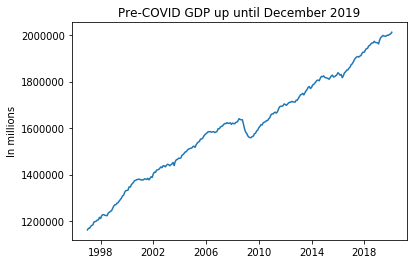

In [3]:
"""We study our samples pre-covid"""

date_range = 2015
start_of_pandemic='2020-03-01'
gdpdf_study = gdpdf[(gdpdf['Period'] < start_of_pandemic)]
plt.plot(gdpdf_study.Period, gdpdf_study.Value)
plt.title("Pre-COVID GDP up until December 2019")
plt.ylabel('In millions')
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
"""Now we apply a simple linear regression on the line"""
X = gdpdf_study.iloc[:, -1:].values
y = gdpdf_study.iloc[:, 1:-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

"""Df of dates from 12/2019 to 12/2022"""


'Df of dates from 12/2019 to 12/2022'

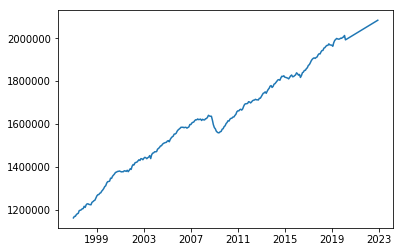

In [5]:
proj_df = pd.DataFrame({
    'Period': pd.date_range(start_of_pandemic,'2022-12-01', 
              freq='MS').tolist()
})
proj_df['ts'] = proj_df['Period'].apply(
    lambda year: ((pd.to_datetime([year]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[0].astype(float)
)
Xpredicted = proj_df.iloc[:, -1:].values
proj_df['Value'] = linear_regressor.predict(Xpredicted)
proj_df = proj_df[['Period', 'Value', 'ts']]
# print(proj_df)
pred_normal_gdp = gdpdf_study.copy()
pred_normal_gdp = pred_normal_gdp.append(proj_df) 
# Our simulated dataframe in normal times up until 2022-12-01
# print(pred_normal_gdp.loc[(pred_normal_gdp['Period'] > '2019-08-01')])

plt.plot(pred_normal_gdp.Period, pred_normal_gdp.Value)

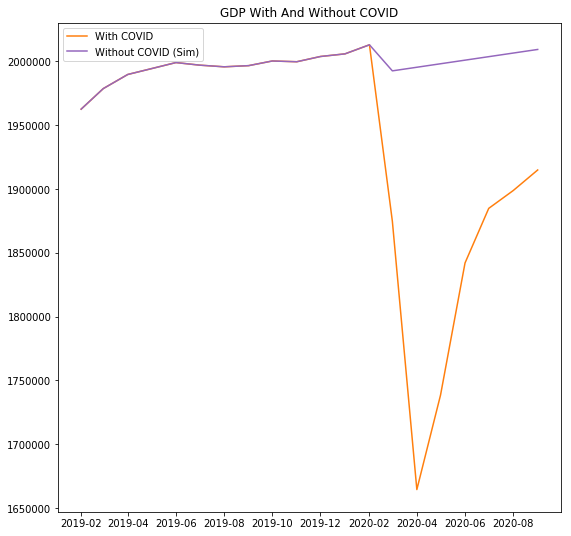

In [9]:
"""Let's now test the accuracy of our prediction over the months of 2020 that we do have"""
min_date = '2019-01-01'
temp = pred_normal_gdp.copy()
temp = temp.loc[(temp['Period'] > min_date)]
temp = temp.loc[(temp['Period'] < '2020-10-01')]
pre_covid = gdpdf[(gdpdf['Period'] > min_date)]

fig, ax = plt.subplots(figsize=(9, 9))
plt.title('GDP With And Without COVID')
ax.plot(pre_covid.Period, pre_covid.Value, 'C1', label='With COVID')
ax.plot(temp.Period, temp.Value, 'C4', label='Without COVID (Sim)')
ax.legend()
plt.show()

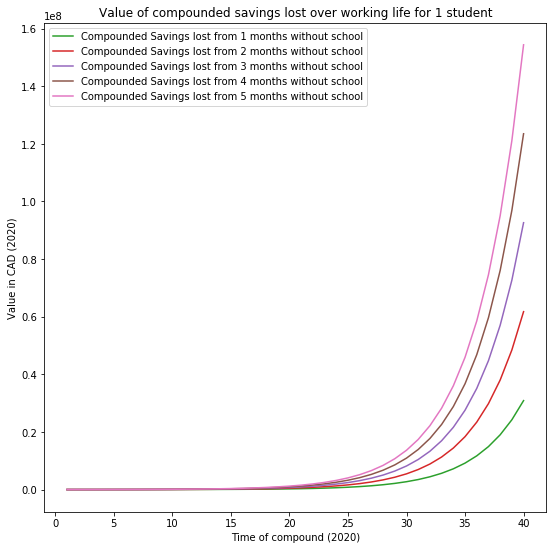

In [166]:
import math
import numpy as np
as_of = "2021-06-01"
temper = pred_normal_gdp.copy()

# Taken from main source in first cell
value_lost_per_child_per_month_usd = 21158.0 #21,158 USD from source
# Taken from bank of canada website
# https://www.bankofcanada.ca/rates/daily-digest/
prime_interest_rate = 0.245 
# We use the average effective tax rate imposed on by taxpayers in 2017
# https://www150.statcan.gc.ca/n1/daily-quotidien/190924/dq190924b-eng.htm
interest_tax_rate = 0.117
# From source in first cell
working_life_from_article = 40
#converting USD 2020 to USD 2012 (year of our gdp date), 
#https://www.in2013dollars.com/us/inflation/2020?endYear=2012&amount=1
value_lost_per_child_per_month_usd_inf = value_lost_per_child_per_month_usd * 0.88
# convert to CAD, take rate on Dec 31 2012
# https://www.poundsterlinglive.com/bank-of-england-spot/historical-spot-exchange-rates/usd/USD-to-CAD-2012
value_lost_per_child_per_month = value_lost_per_child_per_month_usd_inf * 0.9948

compounds = pd.DataFrame({
    'Period': np.arange(1, 41, 1).tolist(),
    'Rate': [prime_interest_rate] * 40
})

fig, ax = plt.subplots(figsize=(9, 9))

plt.title('Value of compounded savings lost over working life for 1 student')
plt.ylabel('Value in CAD (2020)')
plt.xlabel('Time of compound (2020)')

def compound_int(
    p,#monthly contribution
    n,#number of compound periods per year
    r,#interest rate
    y,#number of years
):
    oneplus = (1+(r/n))
    raisedtopower2 = ((n*y))
    ratedividedbynumberoftimes = r/n

    halfdone = (((oneplus**raisedtopower2)-1)/ratedividedbynumberoftimes)
    return p*halfdone

def calculate_costs_for(months=1):
    global ax
    global prime_interest_rate
    global compounds
    amount_lost_over_working_life = value_lost_per_child_per_month * float(months)
    
    amount_lost_per_year_of_working_life = (amount_lost_over_working_life) / working_life_from_article
    
    def apply_compounds(period):
        return compound_int(
            amount_lost_per_year_of_working_life / 12,
            12,
            prime_interest_rate,
            float(period)
        )
    compounds['Amount_{m}'.format(m=months)] = compounds.Period.apply(apply_compounds)
    compounds['Deposited_{m}'.format(m=months)] = amount_of_monthly_deficit_from_202009 * (compounds['Period'] * 12)
    compounds['Interest_{m}'.format(m=months)] = compounds['Amount_{m}'.format(m=months)] - compounds['Deposited_{m}'.format(m=months)]
    compounds['TaxAmount_{m}'.format(m=months)] = compounds['Interest_{m}'.format(m=months)] * interest_tax_rate
    ax.plot(
        compounds['Period'], 
        compounds['Amount_{m}'.format(m=months)], 
        'C{m}'.format(m=months+1), 
        label='Compounded Savings lost from {m} months without school'.format(m=months)
    )
    ax.legend()

for i in range(1, 6):
    calculate_costs_for(i)
plt.show()


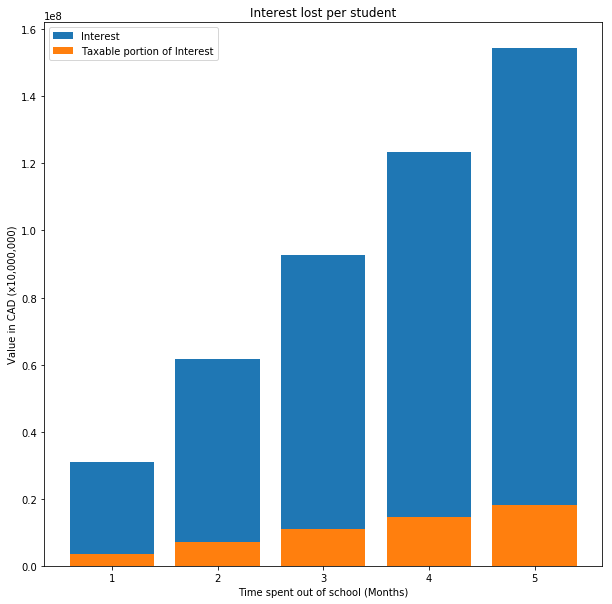

In [171]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Interest lost per student')
plt.ylabel('Value in CAD (x10,000,000)')
plt.xlabel('Time spent out of school (Months)')

values = [compounds['Interest_{m}'.format(m=i)].max() for i in range(1, 6)]
values_tax = [compounds['TaxAmount_{m}'.format(m=i)].max() for i in range(1, 6)]
ax.bar([i for i in range(1, 6)], values)
ax.bar([i for i in range(1, 6)], values_tax)
ax.legend(labels=['Interest', 'Taxable portion of Interest'])
plt.show()

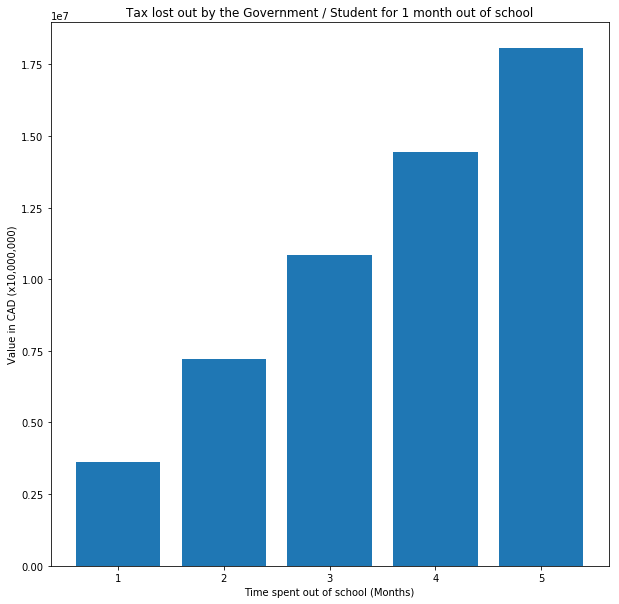

In [178]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Tax lost out by the Government / Student for 1 month out of school')
plt.ylabel('Value in CAD (x10,000,000)')
plt.xlabel('Time spent out of school (Months)')
values_tax = [compounds['TaxAmount_{m}'.format(m=i)].max() for i in range(1, 6)]
ax.bar([i for i in range(1, 6)], values_tax)
plt.show()

In [177]:
abacus = pd.read_csv('data/abacus.csv')
abdf = abacus.copy()
year_studied = pop[pop['Year'] == 2020]
abdf['N'] = abdf.Groups.apply(lambda group: year_studied.iloc[0][group])
abdf['Nmiss'] = abdf['N'] * abdf['Perc']
total_missed_school = abdf['Nmiss'].sum()
# print(abdf)
total_potential_income_tax_lost = compounds['TaxAmount_1'].max()
total_potential_income_tax_lost_for_all_students = total_potential_income_tax_lost * total_missed_school

# This is the total amount of tax the government could have collected from these students over the next 40 years
total_potential_income_tax_lost_for_all_students

875955283471.2686